In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [5]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [6]:
# Encoding labels into numerical values and converting to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset.labels)
num_classes = len(label_encoder.classes_)

In [7]:
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

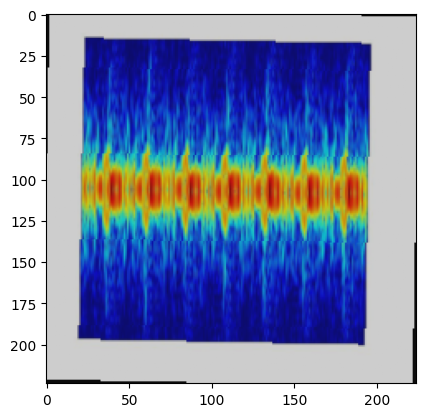

In [12]:
# Visualize one sample
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0]  # Take the first image from the batch
sample_image = sample_image.permute(1, 2, 0)  # Change the dimensions for plotting

# Inverse normalization if necessary (depends on how transforms are applied)
plt.imshow(sample_image)
plt.show()

In [13]:
# Model definitions using VGG16 and VGG19
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize models
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False
model_vgg16 = CustomVGG(vgg16_base, num_classes=6)

vgg19_base = models.vgg19(pretrained=True)
for param in vgg19_base.parameters():
    param.requires_grad = False
model_vgg19 = CustomVGG(vgg19_base, num_classes=6)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1

In [14]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)
model_vgg19.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0001)
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.0001)

In [16]:
# Learning rate scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)
scheduler_vgg19 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [18]:
# Train VGG16 model
train_model(model_vgg16, train_loader, val_loader, criterion, optimizer_vgg16, scheduler_vgg16)

Epoch [1/15], Loss: 0.7281, Accuracy: 0.7435
Validation Loss: 0.3634, Accuracy: 0.9050
Epoch [2/15], Loss: 0.3524, Accuracy: 0.8857
Validation Loss: 0.2497, Accuracy: 0.9174
Epoch [3/15], Loss: 0.2612, Accuracy: 0.9156
Validation Loss: 0.2064, Accuracy: 0.9380
Epoch [4/15], Loss: 0.2180, Accuracy: 0.9248
Validation Loss: 0.1812, Accuracy: 0.9504
Epoch [5/15], Loss: 0.1911, Accuracy: 0.9376
Validation Loss: 0.1462, Accuracy: 0.9587
Epoch [6/15], Loss: 0.1735, Accuracy: 0.9454
Validation Loss: 0.1648, Accuracy: 0.9545
Epoch [7/15], Loss: 0.1584, Accuracy: 0.9529
Validation Loss: 0.1269, Accuracy: 0.9628
Epoch [8/15], Loss: 0.1484, Accuracy: 0.9507
Validation Loss: 0.1132, Accuracy: 0.9711
Epoch [9/15], Loss: 0.1337, Accuracy: 0.9561
Validation Loss: 0.1322, Accuracy: 0.9587
Epoch [10/15], Loss: 0.1231, Accuracy: 0.9626
Validation Loss: 0.1095, Accuracy: 0.9587
Epoch [11/15], Loss: 0.1164, Accuracy: 0.9612
Validation Loss: 0.1059, Accuracy: 0.9752
Epoch [12/15], Loss: 0.1136, Accuracy: 0.

In [19]:
train_model(model_vgg19, train_loader, val_loader, criterion, optimizer_vgg19, scheduler_vgg19)

Epoch [1/15], Loss: 0.7517, Accuracy: 0.7292
Validation Loss: 0.3777, Accuracy: 0.8719
Epoch [2/15], Loss: 0.3759, Accuracy: 0.8741
Validation Loss: 0.2542, Accuracy: 0.9132
Epoch [3/15], Loss: 0.3059, Accuracy: 0.8935
Validation Loss: 0.2299, Accuracy: 0.9174
Epoch [4/15], Loss: 0.2472, Accuracy: 0.9180
Validation Loss: 0.1926, Accuracy: 0.9421
Epoch [5/15], Loss: 0.2277, Accuracy: 0.9255
Validation Loss: 0.1744, Accuracy: 0.9298
Epoch [6/15], Loss: 0.2122, Accuracy: 0.9265
Validation Loss: 0.1415, Accuracy: 0.9545
Epoch [7/15], Loss: 0.1832, Accuracy: 0.9362
Validation Loss: 0.1343, Accuracy: 0.9463
Epoch [8/15], Loss: 0.1843, Accuracy: 0.9388
Validation Loss: 0.1368, Accuracy: 0.9545
Epoch [9/15], Loss: 0.1644, Accuracy: 0.9459
Validation Loss: 0.1382, Accuracy: 0.9545
Epoch [10/15], Loss: 0.1582, Accuracy: 0.9478
Validation Loss: 0.1483, Accuracy: 0.9380
Epoch [11/15], Loss: 0.1243, Accuracy: 0.9604
Validation Loss: 0.1092, Accuracy: 0.9628
Epoch [12/15], Loss: 0.1274, Accuracy: 0.